In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.float_format = "{:.2f}".format

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
DIR_PATH = '/kaggle/input/home-credit-default-risk/'

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
def reduce_mem_usage(df):
    """ Function to iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.  
        Input: dataframe
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Some helpful utility functions

In [3]:
def read_input_file(directory_path = DIR_PATH, fileName= 'application_train.csv', displayHead = True, displayInfo = True, displayStats = True, num_rows = None, verbose=True):
    '''
    Function to load the given input table
    
    Input:
        directory_path: str, default = DIR_PATH
            Path of directory in which table is stored
        fileName: str, default = application_train.csv
            Name of csv file containing the table
        displayHead: bool, default = True
            Display head for pandas dataframe
        displayInfo: bool, default = True
            Display info for pandas dataframe
        displayStats: bool, default = True
            Describe function for pandas dataframe
        num_rows: int, default = None
            Limit pandas read for debug mode or dry run
        verbose: bool, default = True
            Whether to keep verbosity or not
    '''
        
    df = pd.read_csv(directory_path + fileName, nrows= num_rows)
    df = reduce_mem_usage(df)
    if verbose:
        print("Loaded {}... Dataframe contains {}".format(fileName, len(df)))
    if displayHead:
        display(df.head())
    if displayInfo:
        display(df.info(verbose=True, show_counts = True))
    if displayStats:
        display(df.describe().T)
    return df

In [4]:
def one_hot_encoder(df, nan_as_category = False):
    '''
    Function to do one-hot encoding for categorical columns with get_dummies
    
    Input:
        df: Dataframe
            Input dataframe
        nan_as_category: bool, default = False
            Treat NaN as a category
        
    '''
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
def get_nan_percentage(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Input:
        data: DataFrame
   
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [6]:
df = read_input_file()
display(get_nan_percentage(df))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Loaded application_train.csv... Dataframe contains 307511


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype   
---   ------                        --------------   -----   
 0    SK_ID_CURR                    307511 non-null  int32   
 1    TARGET                        307511 non-null  int8    
 2    NAME_CONTRACT_TYPE            307511 non-null  category
 3    CODE_GENDER                   307511 non-null  category
 4    FLAG_OWN_CAR                  307511 non-null  category
 5    FLAG_OWN_REALTY               307511 non-null  category
 6    CNT_CHILDREN                  307511 non-null  int8    
 7    AMT_INCOME_TOTAL              307511 non-null  float32 
 8    AMT_CREDIT                    307511 non-null  float32 
 9    AMT_ANNUITY                   307499 non-null  float32 
 10   AMT_GOODS_PRICE               307233 non-null  float32 
 11   NAME_TYPE_SUITE               306219 non-null  category
 12   NAME_INCOME_TY

None

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.00,278180.52,102790.18,100002.00,189145.50,278202.00,367142.50,456255.00
TARGET,307511.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
CNT_CHILDREN,307511.00,0.42,0.72,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,307511.00,168797.92,237123.14,25650.00,112500.00,147150.00,202500.00,117000000.00
AMT_CREDIT,307511.00,599025.94,402490.78,45000.00,270000.00,513531.00,808650.00,4050000.00
AMT_ANNUITY,307499.00,27108.57,14493.74,1615.50,16524.00,24903.00,34596.00,258025.50
AMT_GOODS_PRICE,307233.00,538396.12,369446.47,40500.00,238500.00,450000.00,679500.00,4050000.00
REGION_POPULATION_RELATIVE,307511.00,0.00,0.00,0.00,0.01,0.02,0.03,0.07
DAYS_BIRTH,307511.00,-16037.00,4363.99,-25229.00,-19682.00,-15750.00,-12413.00,-7489.00
DAYS_EMPLOYED,307511.00,63815.05,141275.77,-17912.00,-2760.00,-1213.00,-289.00,365243.00


,column,percent
76,COMMONAREA_MEDI,69.87
48,COMMONAREA_AVG,69.87
62,COMMONAREA_MODE,69.87
70,NONLIVINGAPARTMENTS_MODE,69.43
56,NONLIVINGAPARTMENTS_AVG,69.43
84,NONLIVINGAPARTMENTS_MEDI,69.43
86,FONDKAPREMONT_MODE,68.39
68,LIVINGAPARTMENTS_MODE,68.35
54,LIVINGAPARTMENTS_AVG,68.35
82,LIVINGAPARTMENTS_MEDI,68.35


In [7]:
target_val_counts = df.TARGET.value_counts(normalize=False)
print(target_val_counts)

0    282686
1     24825
Name: TARGET, dtype: int64


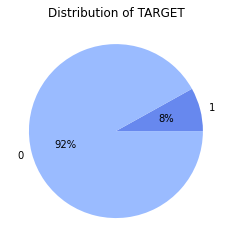

In [8]:
#target_val_ratio = df.TARGET.value_counts(normalize=True)
keyNames = ['1', '0',]
data_dict = target_val_counts.to_dict()
data = [data_dict[int(x)] for x in keyNames] 
# define Seaborn color palette to use
palette_color = sns.color_palette('coolwarm')
# plotting data on chart
plt.pie(data, labels=keyNames, colors=palette_color, autopct='%.0f%%')
plt.title("Distribution of TARGET")
# displaying chart
plt.show()